In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from visualization_utils import (
    ImageType, generate_aim_spec, align_aims, 
    read_image_to_numpy, single_axis_image_and_masks
)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import statsmodels.api as sm

from vtkbone import vtkboneAIMReader

%matplotlib inline

In [3]:

# Hipfx column conversion keys
hipfx_col_conv = {
    'site_e5': 'site',
    'total_area_e5': 'Tt.Ar, reference [mm^2]',
    'totvbmd1_e5': 'Tt.BMD, reference [mg HA / cm^3]',
    'tbar1_e5': 'Tb.Ar, reference [mm^2]',
    'tbvbmd1_e5': 'Tb.BMD, reference [mg HA / cm^3]',
    'tbbvtv_e5': 'Tb.BV/TV, reference [%]',
    'tbn1_e5': 'Tb.N, reference [1/mm]',
    'tbth1_e5': 'Tb.Th, reference [mm]',
    'tbsp1_e5': 'Tb.Sp, reference [mm]',
    'tb1nsd1_e5': 'Tb.1/N.SD, reference [mm]',
    'ctar1_e6': 'Ct.Ar, reference [mm^2]',
    'ctvbmd1_e6': 'Ct.BMD, reference [mg HA / cm^3]',
    'ctpm1_e6': 'Ct.Pm, reference [mm]',
    'ctpo1_e6': 'Ct.Po, reference [%]',
    'ctth1_e6': 'Ct.Th, reference [mm]',
    'ctpodm1_e6': 'Ct.Po.Dm, reference [mm]'
}

hipfx_col_conv_radius = {}
for k,v in hipfx_col_conv.items():
    hipfx_col_conv_radius[f'{k}_r'] = v
    
hipfx_col_conv_tibia_fx = {}
for k,v in hipfx_col_conv.items():
    hipfx_col_conv_tibia_fx[f'{k}_t'] = v

hipfx_col_conv_tibia_no_fx = {}
for k,v in hipfx_col_conv.items():
    hipfx_col_conv_tibia_no_fx[f'{k}_t2'] = v

In [4]:
# Norm column conversion keys
normxtii_col_conv = {
    'site_e5': 'site',
    'total_area_e5': 'Tt.Ar, reference [mm^2]',
    'totvbmd1_e5': 'Tt.BMD, reference [mg HA / cm^3]',
    'tbar1_e5': 'Tb.Ar, reference [mm^2]',
    'tbvbmd1_e5': 'Tb.BMD, reference [mg HA / cm^3]',
    'tbbvtv_e5': 'Tb.BV/TV, reference [%]',
    'tbn1_e5': 'Tb.N, reference [1/mm]',
    'tbth1_e5': 'Tb.Th, reference [mm]',
    'tbsp1_e5': 'Tb.Sp, reference [mm]',
    'tb1nsd1_e5': 'Tb.1/N.SD, reference [mm]',
    'ctar1_e6': 'Ct.Ar, reference [mm^2]',
    'ctvbmd1_e6': 'Ct.BMD, reference [mg HA / cm^3]',
    'ctpm1_e6': 'Ct.Pm, reference [mm]',
    'ctpo1_e6': 'Ct.Po, reference [%]',
    'ctth1_e6': 'Ct.Th, reference [mm]',
    'ctpodm1_e6': 'Ct.Po.Dm, reference [mm]'
}

normxtii_col_conv_radius = {}
for k,v in normxtii_col_conv.items():
    normxtii_col_conv_radius[f'{k}_r'] = v
    
normxtii_col_conv_tibia = {}
for k,v in normxtii_col_conv.items():
    normxtii_col_conv_tibia[f'{k}_t'] = v

In [5]:
# Predicted data conversion key and columns to drop

pred_col_drop = [
    'Meas',
    'MeasDate',
    'Patient',
    'Site'
]
    
pred_col_conv = {
    'Filename': 'label',
    'BA.CtAr': 'BA.Ct.Ar, predicted [mm^2]',
    'BA.TtAr': 'BA.Tt.Ar, predicted [mm^2]',
    'BA.TbAr': 'BA.Tb.Ar, predicted [mm^2]',
    'BMD': 'Tt.BMD, predicted [mg HA / cm^3]',
    'BVTV': 'Tb.BV/TV, predicted [%]',
    'ConnD': 'Conn.D, predicted [1/mm^3]',
    'CtAr': 'Ct.Ar, predicted [mm^2]',
    'CtBMD': 'Ct.BMD, predicted [mg HA / cm^3]',
    'CtPm': 'Ct.Pm, predicted [mm]',
    'CtPo': 'Ct.Po, predicted [%]',
    'CtPoDm': 'Ct.Po.Dm, predicted [mm]',
    'CtTMD': 'Ct.TMD, predicted [mg HA / cm^3]',
    'CtTh': 'Ct.Th, predicted [mm]',
    'DA': 'DA, predicted [-]',
    'SMI': 'SMI, predicted [-]',
    'TMD': 'TMD, predicted [mg Ha / cm^3]',
    'Tb1NSD': 'Tb.1/N.SD, predicted [mm]',
    'TbAr': 'Tb.Ar, predicted [mm^2]',
    'TbBMD': 'Tb.BMD, predicted [mg HA / cm^3]',
    'TbN': 'Tb.N, predicted [1/mm]',
    'TbSp': 'Tb.Sp, predicted [mm]',
    'TbTMD': 'Tb.TMD, predicted [mg HA / cm^3]',
    'TbTh': 'Tb.Th, predicted [mm]',
    'TtAr': 'Tt.Ar, predicted [mm^2]',
}



In [6]:
# raw reference data import
df_hipfx_raw = pd.read_csv('/Users/nathanneeteson/Documents/Data/HIPFX/data.csv')
df_normxtii_raw = pd.read_csv('/Users/nathanneeteson/Documents/Data/NORMXTII/data.csv')

we want to take all of the data from both of these raw reference datasets and parse it into a single reference dataset where each row corresponds to a single measurement and where each column contains presentable and readable information about the record ID, label, site, data, etc.

to do this we need to break apart these dataframes into separate dataframes for the radiuses and tibias, and then append them back together after

In [7]:
# deal with normxtii first because it's easier:

# radius images

normxtii_radius_columns = ['record_id'] + [col for col in df_normxtii_raw.columns if col.endswith('_r')]

df_normxtii_radius = df_normxtii_raw[normxtii_radius_columns].copy()
df_normxtii_radius = df_normxtii_radius.rename(columns=normxtii_col_conv_radius)

df_normxtii_radius['label'] = df_normxtii_radius['record_id']+'_R'+df_normxtii_radius['site'].str[-1]
df_normxtii_radius.set_index('label',inplace=True)

# tibia images

normxtii_tibia_columns = ['record_id'] + [col for col in df_normxtii_raw.columns if col.endswith('_t')]

df_normxtii_tibia = df_normxtii_raw[normxtii_tibia_columns].copy()
df_normxtii_tibia = df_normxtii_tibia.rename(columns=normxtii_col_conv_tibia)

df_normxtii_tibia['label'] = df_normxtii_tibia['record_id']+'_T'+df_normxtii_tibia['site'].str[-1]
df_normxtii_tibia.set_index('label',inplace=True)



In [8]:
# now deal with hipfx

# radius images

hipfx_radius_columns = ['record_id'] + [col for col in df_hipfx_raw.columns if col.endswith('_r')]

df_hipfx_radius = df_hipfx_raw[hipfx_radius_columns].copy()
df_hipfx_radius = df_hipfx_radius.rename(columns=hipfx_col_conv_radius)

df_hipfx_radius['label'] = df_hipfx_radius['record_id']+'_R'+df_hipfx_radius['site'].str[-1]
df_hipfx_radius.set_index('label',inplace=True)

# tibia fx images

hipfx_tibia_fx_columns = ['record_id'] + [col for col in df_hipfx_raw.columns if col.endswith('_t')]

df_hipfx_tibia_fx = df_hipfx_raw[hipfx_tibia_fx_columns].copy()
df_hipfx_tibia_fx = df_hipfx_tibia_fx.rename(columns=hipfx_col_conv_tibia_fx)

df_hipfx_tibia_fx['label'] = df_hipfx_tibia_fx['record_id']+'_T'+df_hipfx_tibia_fx['site'].str[-1]
df_hipfx_tibia_fx.set_index('label',inplace=True)

# tibia no fx images

hipfx_tibia_no_fx_columns = ['record_id'] + [col for col in df_hipfx_raw.columns if col.endswith('_t2')]

df_hipfx_tibia_no_fx = df_hipfx_raw[hipfx_tibia_no_fx_columns].copy()
df_hipfx_tibia_no_fx = df_hipfx_tibia_no_fx.rename(columns=hipfx_col_conv_tibia_no_fx)

df_hipfx_tibia_no_fx['label'] = df_hipfx_tibia_no_fx['record_id']+'_T'+df_hipfx_tibia_no_fx['site'].str[-1]
df_hipfx_tibia_no_fx.set_index('label',inplace=True)

# for the tibias in hipfx, we might only have one of the two and not both for a given participant.
# so we need to drop rows containing N/A values for both of these dataframes before proceeding, to
# make sure we only keep rows that actually have data.

df_hipfx_tibia_fx.dropna(inplace=True)
df_hipfx_tibia_no_fx.dropna(inplace=True)


In [9]:
# now we just merge all of these dataframes together to get the reference dataset

df_reference = pd.concat([
    df_normxtii_radius,
    df_normxtii_tibia,
    df_hipfx_radius,
    df_hipfx_tibia_fx,
    df_hipfx_tibia_no_fx
])

In [10]:
df_reference.drop(columns=["totalarea_e6_t"],inplace=True)

The reference data import and cleanign is complete, now we import the predicted data.

In [11]:
df_predicted = pd.read_csv('eval_logs/test_data.csv')

In [12]:
# get rid of all of the useless unit columns

keep_columns = [col for col in df_predicted.columns if 'units' not in col]
df_predicted = df_predicted[keep_columns].copy()


In [13]:
# drop the unneeded columns and rename the others, and set the label column to the index

df_predicted.drop(pred_col_drop,axis=1,inplace=True)
df_predicted = df_predicted.rename(columns=pred_col_conv)

df_predicted.set_index('label',inplace=True)


In [14]:
df_predicted.columns

Index(['BA.Ct.Ar, predicted [mm^2]', 'BA.Tb.Ar, predicted [mm^2]',
       'BA.Tt.Ar, predicted [mm^2]', 'Tt.BMD, predicted [mg HA / cm^3]',
       'Tb.BV/TV, predicted [%]', 'Conn.D, predicted [1/mm^3]',
       'Ct.Ar, predicted [mm^2]', 'Ct.BMD, predicted [mg HA / cm^3]',
       'Ct.Pm, predicted [mm]', 'Ct.Po, predicted [%]',
       'Ct.Po.Dm, predicted [mm]', 'Ct.TMD, predicted [mg HA / cm^3]',
       'Ct.Th, predicted [mm]', 'DA, predicted [-]', 'SMI, predicted [-]',
       'TMD, predicted [mg Ha / cm^3]', 'Tb.1/N.SD, predicted [mm]',
       'Tb.Ar, predicted [mm^2]', 'Tb.BMD, predicted [mg HA / cm^3]',
       'Tb.N, predicted [1/mm]', 'Tb.Sp, predicted [mm]',
       'Tb.TMD, predicted [mg HA / cm^3]', 'Tb.Th, predicted [mm]',
       'Tt.Ar, predicted [mm^2]'],
      dtype='object')

With all of the data cleaned and imported, the next step is to merge the reference and predicted datasets so that we can plot reference and predicted data against each other.

In [15]:
df = df_reference.join(df_predicted)
df.dropna(inplace=True)


In [16]:
# now let's establish all of the lists we need to automate generating comparative plots
all_params = True

if all_params:
    params_and_units = [
        ('Tt.BMD', 'mg HA / cm^3'),
        ('Ct.BMD', 'mg HA / cm^3'),
        ('Tb.BMD', 'mg HA / cm^3'),
        ('Ct.Th', 'mm'),
        ('Ct.Po', '%'),
        ('Tb.N', '1/mm'),
        ('Tb.BV/TV', '%'),
        ('Tb.Th', 'mm'),
        ('Tb.Sp', 'mm'),
        ('Tt.Ar', 'mm^2'),
        ('Ct.Ar', 'mm^2'),
        ('Tb.Ar', 'mm^2')
    ]
else:
    params_and_units = [
        ('Ct.Th', 'mm'),
        ('Ct.Po', '%'),
        ('Tb.BV/TV', '%'),
        ('Tb.Sp', 'mm')
    ]

ylim = {
    'Tt.BMD': [-120, 120],
    'Ct.BMD': [-120,120],
    'Ct.Th': [-0.5,0.5],
    'Ct.Po': [-1.3,1.3],
    'Ct.Ar': [-20,20],
    'Tb.BMD': [-30,30],
    'Tb.N': [-0.05,0.05],
    'Tb.BV/TV': [-2.5,2.5],
    'Tb.Th': [-0.03,0.03],
    'Tb.Sp': [-0.1,0.1],
    'Tb.Ar': [-20,20],
    'Tt.Ar': [-20,20]
}

full_param_name = {
    'Tt.BMD': 'Total Volumetric Bone Mineral Density',
    'Ct.BMD': 'Cortical Volumetric Bone Mineral Density',
    'Ct.Th': 'Cortical Thickness',
    'Ct.Po': 'Cortical Porosity',
    'Ct.Ar': 'Cortical Area',
    'Tb.BMD': 'Trabecular Volumetric Bone Mineral Density',
    'Tb.N': 'Trabecular Number',
    'Tb.BV/TV': 'Trabecular Bone Volume Fraction',
    'Tb.Th': 'Trabecular Thickness',
    'Tb.Sp': 'Trabecular Separation',
    'Tb.Ar': 'Trabecular Area',
    'Tt.Ar': 'Total Area'
}

In [17]:
# calculate the mean and difference for each sample and each parameter
for (param, unit) in params_and_units:
    df[f'{param}, mean [{unit}]'] = (df[f'{param}, reference [{unit}]'] + df[f'{param}, predicted [{unit}]'])/2
    df[f'{param}, difference [{unit}]'] = df[f'{param}, predicted [{unit}]'] - df[f'{param}, reference [{unit}]']

In [27]:
# define a function to create linear correlation and bland-altman plots
def create_lin_corr_and_bland_altman(axs, df, site, param, unit, max_value_mult, fontsize):
    axs[0].grid()
    axs[0].axis('equal')

    min_value = min(
        df[f'{param}, reference [{unit}]'].min(),
        df[f'{param}, predicted [{unit}]'].min(),
    )

    max_value = max(
        df[f'{param}, reference [{unit}]'].max(),
        df[f'{param}, predicted [{unit}]'].max(),
    )

    axs[0].plot(
        [0, max_value_mult*max_value],
        [0, max_value_mult*max_value],
        'k-'
    )

    X = sm.add_constant(df[df['site'].apply(lambda x: site in x)][f'{param}, reference [{unit}]'].values)
    y = df[df['site'].apply(lambda x: site in x)][f'{param}, predicted [{unit}]'].values

    model = sm.OLS(y,X)
    results = model.fit()
    slope = results.params[1]
    intercept = results.params[0]

    axs[0].plot(
        [0, max_value_mult*max_value],
        [intercept, intercept + slope*max_value_mult*max_value],
        'r--'
    )

    sns.scatterplot(
        data=df[df['site'].apply(lambda x: site in x)],
        ax=axs[0],
        x=f'{param}, reference [{unit}]',
        y=f'{param}, predicted [{unit}]',
        color='black'
    )

    axs[0].set_xlabel(f'Reference {param}', fontsize=fontsize)
    axs[0].set_ylabel(f'Predicted {param}', fontsize=fontsize)

    axs[0].set_xlim([min_value/max_value_mult,max_value_mult*max_value])
    axs[0].set_ylim([min_value/max_value_mult,max_value_mult*max_value])


    # bland altman mean difference plot

    axs[1].grid()

    min_mean = df[f'{param}, mean [{unit}]'].min()
    max_mean = df[f'{param}, mean [{unit}]'].max()

    max_diff = df[f'{param}, difference [{unit}]'].abs().max()

    axs[1].plot(
        [min_mean/max_value_mult, max_value_mult*max_mean],
        [0, 0],
        'k-'
    )

    bias = df[df['site'].apply(lambda x: site in x)][f'{param}, difference [{unit}]'].mean()

    diff_std = df[df['site'].apply(lambda x: site in x)][f'{param}, difference [{unit}]'].std()
    diff_ste = diff_std / np.sqrt(len(df[df['site'].apply(lambda x: site in x)][f'{param}, difference [{unit}]']))
    diff_moe = 1.96*diff_std

    loa_low = bias - diff_moe
    loa_upp = bias + diff_moe

    axs[1].plot(
        [min_mean/max_value_mult, max_value_mult*max_mean],
        [bias, bias],
        'r-'
    )

    axs[1].plot(
        [min_mean/max_value_mult, max_value_mult*max_mean],
        [loa_low, loa_low],
        'r--'
    )

    axs[1].plot(
        [min_mean/max_value_mult, max_value_mult*max_mean],
        [loa_upp, loa_upp],
        'r--'
    )

    sns.scatterplot(
        data=df[df['site'].apply(lambda x: site in x)],
        ax=axs[1],
        x=f'{param}, mean [{unit}]',
        y=f'{param}, difference [{unit}]',
        color='black'
    )

    axs[1].set_xlabel(f'Mean {param}', fontsize=fontsize)
    axs[1].set_ylabel(f'Difference (Ref. - Pred.)', fontsize=fontsize)

    axs[1].set_xlim([min_mean/max_value_mult, max_value_mult*max_mean])
    axs[1].set_ylim([-max_value_mult*max_diff,max_value_mult*max_diff])

In the following cell, figures 5, S1, and S2 are generated:

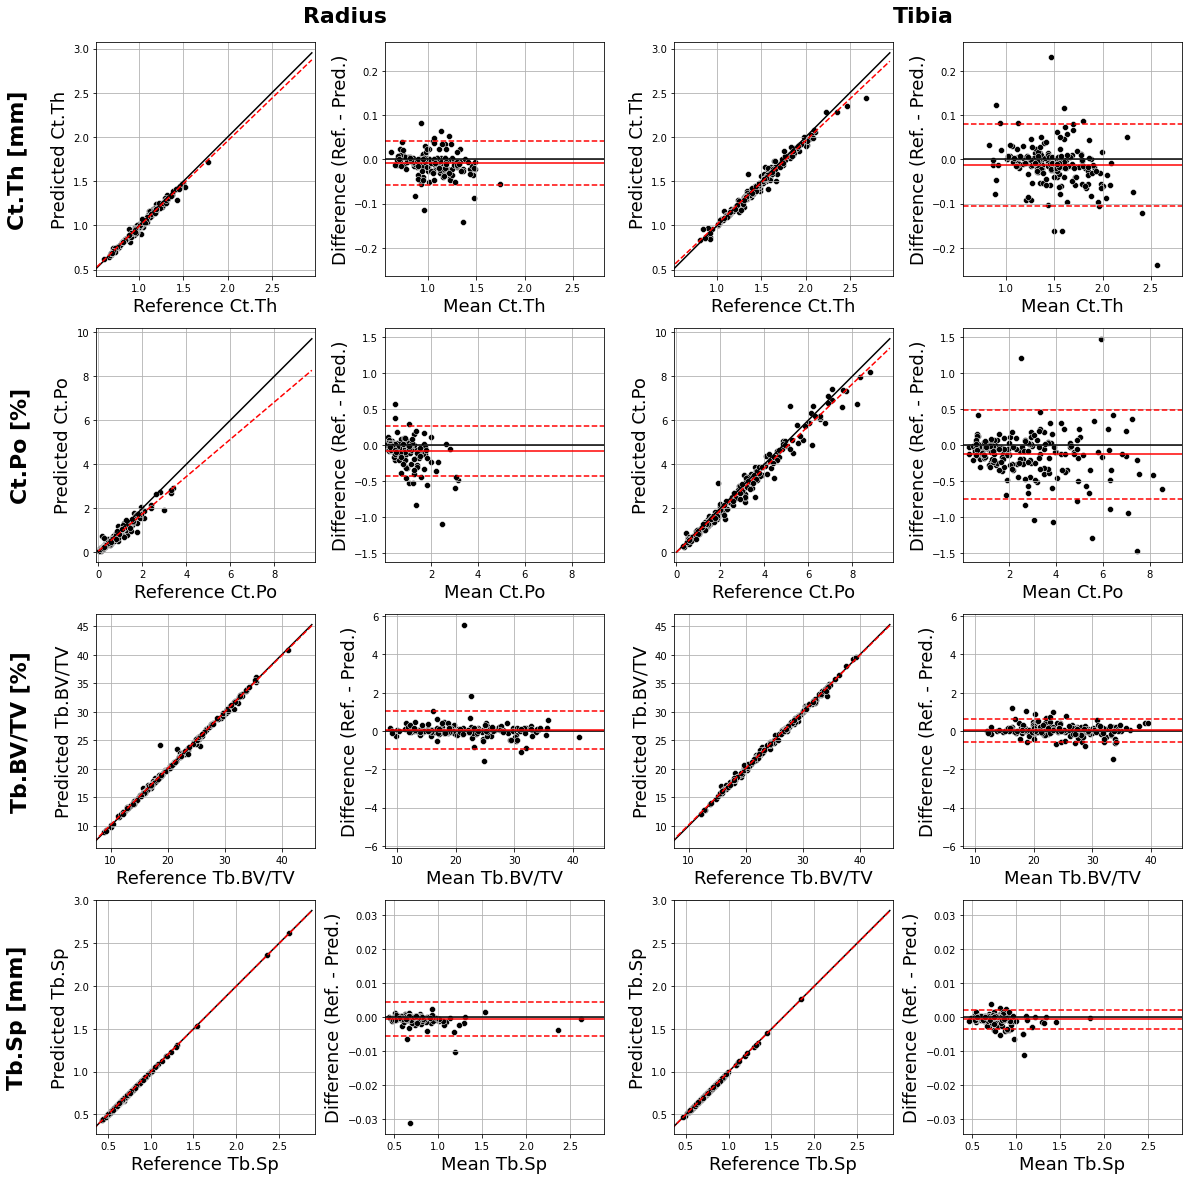

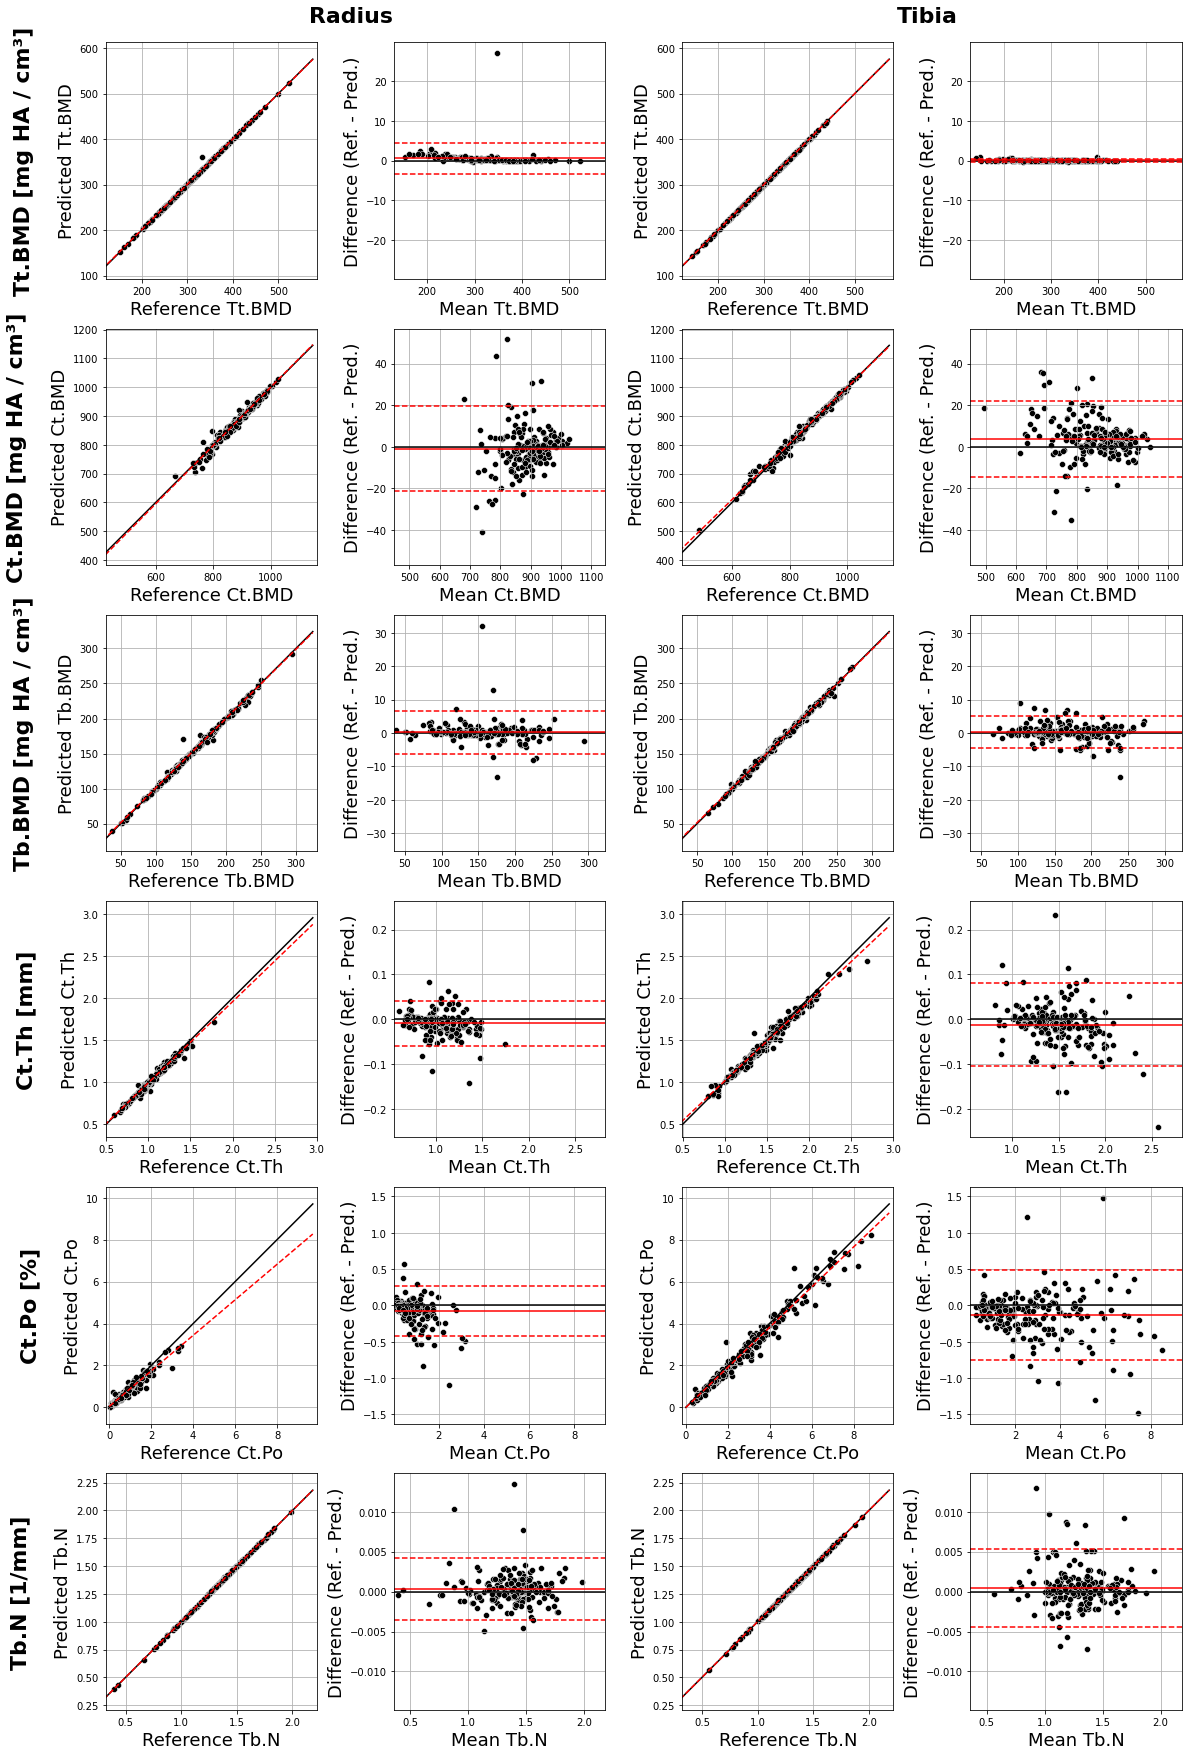

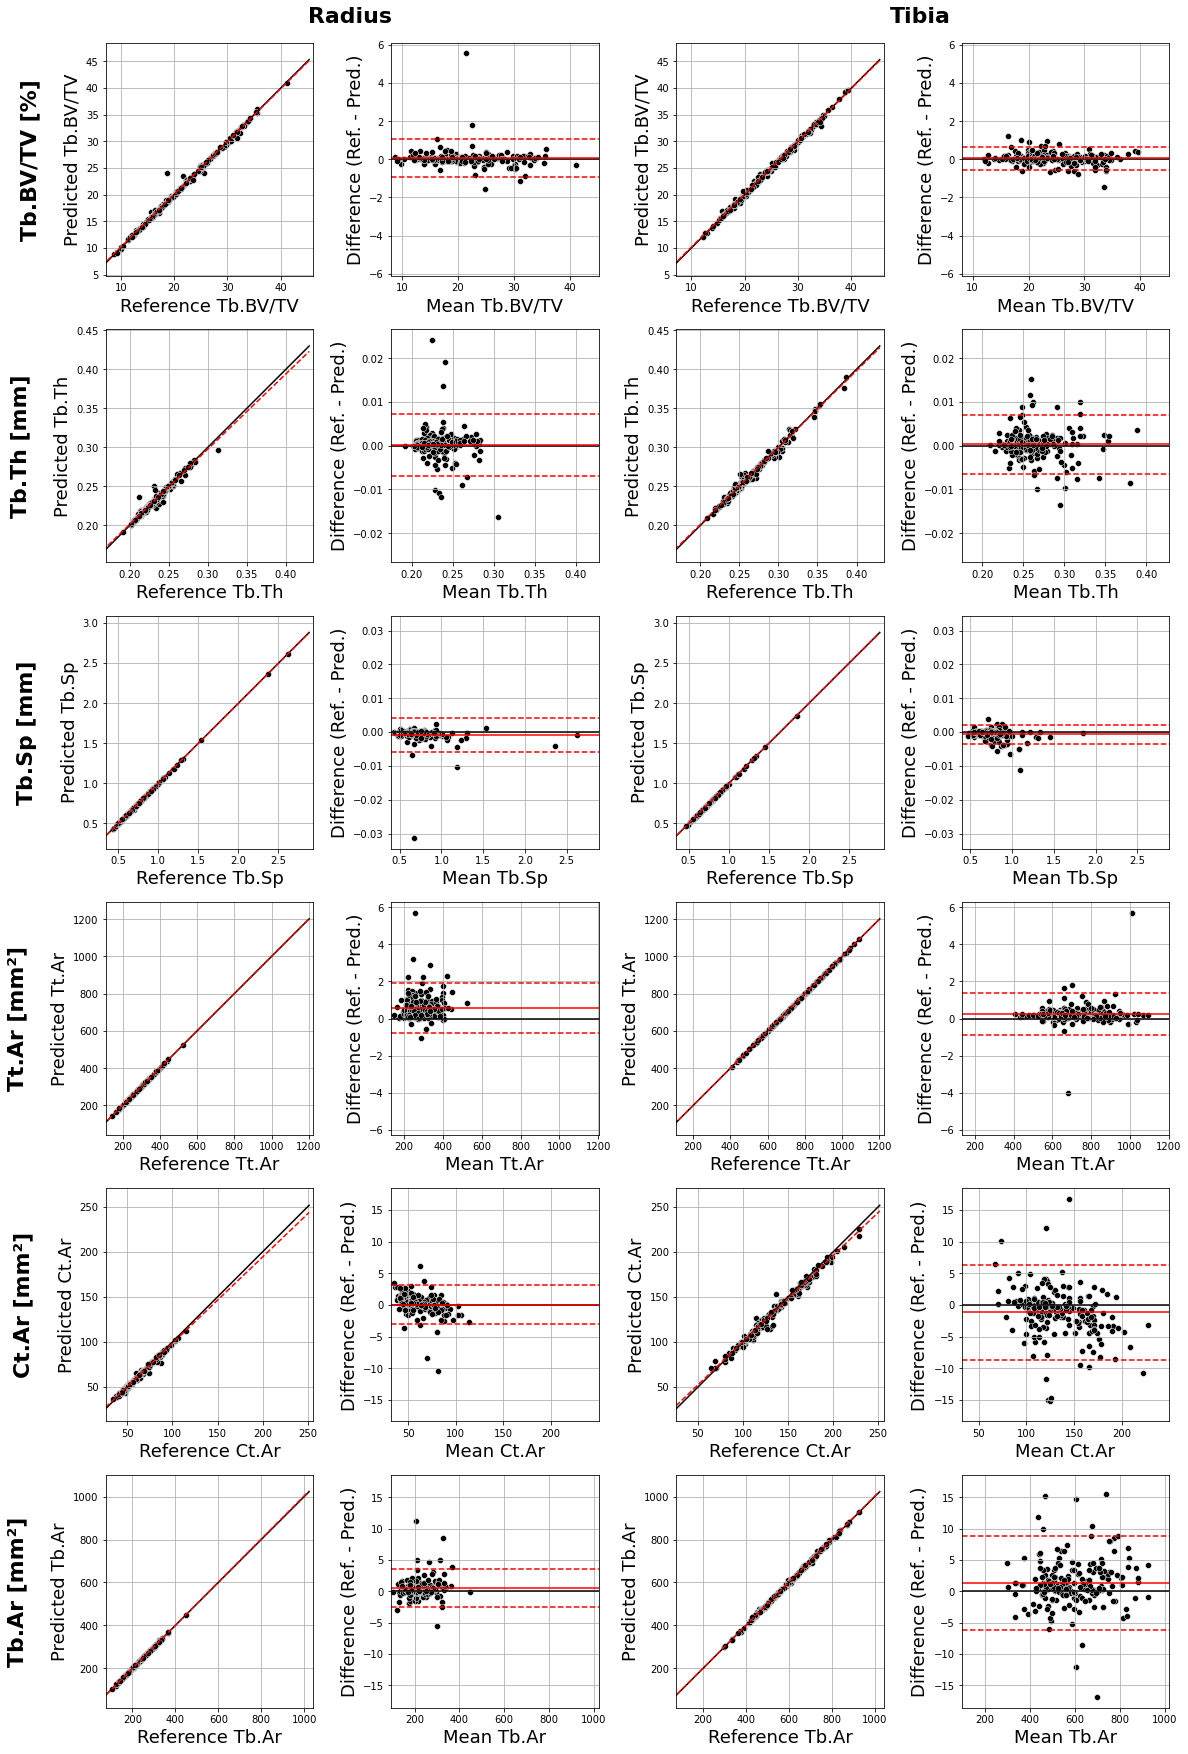

In [74]:
import re

def to_superscript(num):
    transl = str.maketrans(dict(zip('1234567890', '¹²³⁴⁵⁶⁷⁸⁹⁰')))
    return num.translate(transl)

max_value_mult = 1.1
fontsize = 18
col_hpad = 140
col_vpad = 20
row_hpad = 20
header_fontsize = 22


sites = ["Radius", "Tibia"]

# Figure 5
# --------
params_and_units = [
    ('Ct.Th', 'mm'),
    ('Ct.Po', '%'),
    ('Tb.BV/TV', '%'),
    ('Tb.Sp', 'mm')
]

fig, axs = plt.subplots(len(params_and_units),2*len(sites),figsize=(8*len(sites),4*len(params_and_units)))
for i, (param, unit) in enumerate(params_and_units):
    for j, site in enumerate(sites):
        create_lin_corr_and_bland_altman(axs[i][(2*j):(2*(j+1))], df, site, param, unit, max_value_mult, fontsize)     
plt.tight_layout()
for i, site in enumerate(sites):
    axs[0][2*i].annotate(
        site,
        xy=(0.5, 1), xytext=(col_hpad, col_vpad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline', 
        fontsize=header_fontsize, weight="bold"
    )
for i, (param, unit) in enumerate(params_and_units):
    unit = re.sub('\^\s*(\d+)', lambda m: to_superscript(m[1]), unit)
    axs[i][0].annotate(f"{param} [{unit}]", 
        xy=(0, 0.5), xytext=(-axs[i][0].yaxis.labelpad - row_hpad, 0),
        xycoords=axs[i][0].yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', 
        fontsize=header_fontsize, weight="bold",
        rotation=90
    )
plt.savefig(f'figures/Figure5.eps', format='eps', bbox_inches="tight")
plt.show()

# Figure S1
params_and_units = [
    ('Tt.BMD', 'mg HA / cm^3'),
    ('Ct.BMD', 'mg HA / cm^3'),
    ('Tb.BMD', 'mg HA / cm^3'),
    ('Ct.Th', 'mm'),
    ('Ct.Po', '%'),
    ('Tb.N', '1/mm')
]
fig, axs = plt.subplots(len(params_and_units),2*len(sites),figsize=(8*len(sites),4*len(params_and_units)))
for i, (param, unit) in enumerate(params_and_units):
    for j, site in enumerate(sites):
        create_lin_corr_and_bland_altman(axs[i][(2*j):(2*(j+1))], df, site, param, unit, max_value_mult, fontsize)     
plt.tight_layout()
for i, site in enumerate(sites):
    axs[0][2*i].annotate(
        site,
        xy=(0.5, 1), xytext=(col_hpad, col_vpad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline', 
        fontsize=header_fontsize, weight="bold"
    )
for i, (param, unit) in enumerate(params_and_units):
    unit = re.sub('\^\s*(\d+)', lambda m: to_superscript(m[1]), unit)
    axs[i][0].annotate(f"{param} [{unit}]", 
        xy=(0, 0.5), xytext=(-axs[i][0].yaxis.labelpad - row_hpad, 0),
        xycoords=axs[i][0].yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', 
        fontsize=header_fontsize, weight="bold",
        rotation=90
    )
plt.savefig(f'figures/FigureS1.eps', format='eps', bbox_inches="tight")
plt.show()

# Figure S2
params_and_units = [
    ('Tb.BV/TV', '%'),
    ('Tb.Th', 'mm'),
    ('Tb.Sp', 'mm'),
    ('Tt.Ar', 'mm^2'),
    ('Ct.Ar', 'mm^2'),
    ('Tb.Ar', 'mm^2')
]
fig, axs = plt.subplots(len(params_and_units),2*len(sites),figsize=(8*len(sites),4*len(params_and_units)))
for i, (param, unit) in enumerate(params_and_units):
    for j, site in enumerate(sites):
        create_lin_corr_and_bland_altman(axs[i][(2*j):(2*(j+1))], df, site, param, unit, max_value_mult, fontsize)     
plt.tight_layout()
for i, site in enumerate(sites):
    axs[0][2*i].annotate(
        site,
        xy=(0.5, 1), xytext=(col_hpad, col_vpad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline', 
        fontsize=header_fontsize, weight="bold"
    )
for i, (param, unit) in enumerate(params_and_units):
    unit = re.sub('\^\s*(\d+)', lambda m: to_superscript(m[1]), unit)
    axs[i][0].annotate(f"{param} [{unit}]", 
        xy=(0, 0.5), xytext=(-axs[i][0].yaxis.labelpad - row_hpad, 0),
        xycoords=axs[i][0].yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', 
        fontsize=header_fontsize, weight="bold",
        rotation=90
    )
plt.savefig(f'figures/FigureS2.eps', format='eps', bbox_inches="tight")
plt.show()

In [19]:
(len(df[df['site'].apply(lambda x: 'Radius' in x)]),len(df[df['site'].apply(lambda x: 'Tibia' in x)]))

(185, 201)

In [20]:
params_and_units = [
    ('Tt.BMD', 'mg HA / cm^3'),
    ('Ct.BMD', 'mg HA / cm^3'),
    ('Tb.BMD', 'mg HA / cm^3'),
    ('Ct.Th', 'mm'),
    ('Ct.Po', '%'),
    ('Tb.BV/TV', '%'),
    ('Tb.N', '1/mm'),
    ('Tb.Th', 'mm'),
    ('Tb.Sp', 'mm'),
    ('Tt.Ar', 'mm^2'),
    ('Ct.Ar', 'mm^2'),
    ('Tb.Ar', 'mm^2')
]

sig_thresh = 0.05

hlinelength = 110

print('='*hlinelength)
print('Parameter | Slope, 95% C.I.       | Intercept, 95% C.I.         | Abs. Error: median (max)    | R2')
print('='*hlinelength)

for param_and_unit in params_and_units:
    
    param = param_and_unit[0]
    unit = param_and_unit[1]
    
    X = sm.add_constant(df[f'{param}, reference [{unit}]'].values)
    y = df[f'{param}, predicted [{unit}]'].values
    
    model = sm.OLS(y,X)
    results = model.fit()
    
    slope_t_test = results.t_test('x1=1')
    slope_sig = '*' if slope_t_test.pvalue<sig_thresh else ' '
    
    int_t_test = results.t_test('const=0')
    int_sig = '*' if int_t_test.pvalue<sig_thresh else ' '
    
    error = np.abs( df[f'{param}, predicted [{unit}]'].values - df[f'{param}, reference [{unit}]'].values )
    
    slope = results.params[1]
    slope_ci_min = slope - 1.96*results.bse[1]
    slope_ci_max = slope + 1.96*results.bse[1]
    
    intercept = results.params[0]
    intercept_ci_min = intercept - 1.96*results.bse[0]
    intercept_ci_max = intercept + 1.96*results.bse[0]
    
    R2 = results.rsquared
    
    print(f'{param:9s} | {slope:5.3f} ({slope_ci_min:5.3f},{slope_ci_max:5.3f}) {slope_sig} | {intercept:7.3f} ({intercept_ci_min:7.3f},{intercept_ci_max:7.3f}) {int_sig} | {np.median(error):6.3f} ({error.max():5.2f}) {unit:12s} | {R2:0.3f}')

print('='*hlinelength)
print(f'Null hypotheses: slope = 1, intercept = 0. | * - reject the null hypothesis (p<{sig_thresh})')



Parameter | Slope, 95% C.I.       | Intercept, 95% C.I.         | Abs. Error: median (max)    | R2
Tt.BMD    | 0.998 (0.996,1.000)   |   0.953 (  0.275,  1.630) * |  0.177 (27.04) mg HA / cm^3 | 1.000
Ct.BMD    | 0.981 (0.970,0.993) * |  17.759 (  7.462, 28.056) * |  4.670 (51.68) mg HA / cm^3 | 0.986
Tb.BMD    | 0.990 (0.984,0.997) * |   1.803 (  0.746,  2.860) * |  0.805 (32.18) mg HA / cm^3 | 0.996
Ct.Th     | 0.967 (0.956,0.977) * |   0.032 (  0.018,  0.046) * |  0.016 ( 0.24) mm           | 0.988
Ct.Po     | 0.955 (0.941,0.969) * |  -0.020 ( -0.057,  0.016)   |  0.090 ( 1.48) %            | 0.979
Tb.BV/TV  | 0.991 (0.985,0.998) * |   0.249 (  0.096,  0.402) * |  0.110 ( 5.55) %            | 0.996
Tb.N      | 1.000 (0.999,1.001)   |   0.001 ( -0.001,  0.002)   |  0.001 ( 0.01) 1/mm         | 1.000
Tb.Th     | 0.985 (0.973,0.996) * |   0.004 (  0.001,  0.007) * |  0.001 ( 0.02) mm           | 0.987
Tb.Sp     | 0.998 (0.998,0.999) * |   0.000 ( -0.000,  0.001)   |  0.001 ( 0.03) mm  

In [21]:
sig_thresh = 0.05

hlinelength = 110

for site in ['Radius', 'Tibia']:
    print('='*hlinelength)
    print(f'{site:9s} | Slope, 95% C.I.       | Intercept, 95% C.I.         | R2')
    print('='*hlinelength)
    for param_and_unit in params_and_units:

        param = param_and_unit[0]
        unit = param_and_unit[1]

        X = sm.add_constant(df[df['site'].apply(lambda x: site in x)][f'{param}, reference [{unit}]'].values)
        y = df[df['site'].apply(lambda x: site in x)][f'{param}, predicted [{unit}]'].values

        model = sm.OLS(y,X)
        results = model.fit()

        slope_t_test = results.t_test('x1=1')
        slope_sig = '*' if slope_t_test.pvalue<sig_thresh else ' '

        int_t_test = results.t_test('const=0')
        int_sig = '*' if int_t_test.pvalue<sig_thresh else ' '

        slope = results.params[1]
        slope_ci_min = slope - 1.96*results.bse[1]
        slope_ci_max = slope + 1.96*results.bse[1]

        intercept = results.params[0]
        intercept_ci_min = intercept - 1.96*results.bse[0]
        intercept_ci_max = intercept + 1.96*results.bse[0]

        R2 = results.rsquared

        print(f'{param:9s} | {slope:5.3f} ({slope_ci_min:5.3f},{slope_ci_max:5.3f}) {slope_sig} | {intercept:7.3f} ({intercept_ci_min:7.3f},{intercept_ci_max:7.3f}) {int_sig} | {R2:0.3f}')

print('='*hlinelength)
print(f'Null hypotheses: slope = 1, intercept = 0. | * - reject the null hypothesis (p<{sig_thresh})')

Radius    | Slope, 95% C.I.       | Intercept, 95% C.I.         | R2
Tt.BMD    | 0.995 (0.991,1.000) * |   2.046 (  0.647,  3.444) * | 0.999
Ct.BMD    | 1.013 (0.990,1.037)   | -12.660 (-33.648,  8.328)   | 0.975
Tb.BMD    | 0.990 (0.980,1.000)   |   1.750 (  0.099,  3.400) * | 0.995
Ct.Th     | 0.963 (0.946,0.980) * |   0.030 (  0.012,  0.048) * | 0.986
Ct.Po     | 0.847 (0.816,0.878) * |   0.050 (  0.016,  0.083) * | 0.938
Tb.BV/TV  | 0.991 (0.980,1.001)   |   0.252 (  0.004,  0.500) * | 0.994
Tb.N      | 1.000 (0.999,1.001)   |   0.000 ( -0.001,  0.002)   | 1.000
Tb.Th     | 0.964 (0.939,0.988) * |   0.009 (  0.003,  0.014) * | 0.970
Tb.Sp     | 0.999 (0.997,1.000)   |   0.000 ( -0.001,  0.001)   | 1.000
Tt.Ar     | 1.001 (1.000,1.003)   |   0.234 ( -0.201,  0.668)   | 1.000
Ct.Ar     | 0.957 (0.944,0.971) * |   2.740 (  1.877,  3.604) * | 0.991
Tb.Ar     | 1.004 (1.000,1.008) * |  -0.456 ( -1.349,  0.436)   | 0.999
Tibia     | Slope, 95% C.I.       | Intercept, 95% C.I.         | R

In [22]:
for site in ['Radius', 'Tibia']:
    print('='*hlinelength)
    print(f'{site:9s} | Bias (95% LOA)')
    print('='*hlinelength)
    for param_and_unit in params_and_units:

        param = param_and_unit[0]
        unit = param_and_unit[1]
        
        bias = df[df['site'].apply(lambda x: site in x)][f'{param}, difference [{unit}]'].mean()
        
        diff_std = df[df['site'].apply(lambda x: site in x)][f'{param}, difference [{unit}]'].std()
        diff_ste = diff_std / np.sqrt(len(df[df['site'].apply(lambda x: site in x)][f'{param}, difference [{unit}]']))
        diff_moe = 1.96*diff_std
        
        loa_low = bias - diff_moe
        loa_upp = bias + diff_moe
        
        print(f'{param:9s} | {bias:8.3f} ({loa_low:8.3f},{loa_upp:8.3f})')
        

Radius    | Bias (95% LOA)
Tt.BMD    |    0.594 (  -3.361,   4.550)
Ct.BMD    |   -0.843 ( -21.415,  19.729)
Tb.BMD    |    0.232 (  -6.181,   6.645)
Ct.Th     |   -0.009 (  -0.059,   0.041)
Ct.Po     |   -0.078 (  -0.427,   0.270)
Tb.BV/TV  |    0.047 (  -0.946,   1.039)
Tb.N      |    0.000 (  -0.004,   0.004)
Tb.Th     |    0.000 (  -0.007,   0.007)
Tb.Sp     |   -0.001 (  -0.006,   0.004)
Tt.Ar     |    0.574 (  -0.757,   1.906)
Ct.Ar     |    0.066 (  -3.089,   3.221)
Tb.Ar     |    0.482 (  -2.551,   3.514)
Tibia     | Bias (95% LOA)
Tt.BMD    |    0.065 (  -0.247,   0.377)
Ct.BMD    |    3.814 ( -14.331,  21.958)
Tb.BMD    |    0.269 (  -4.416,   4.954)
Ct.Th     |   -0.012 (  -0.105,   0.080)
Ct.Po     |   -0.129 (  -0.752,   0.494)
Tb.BV/TV  |    0.044 (  -0.548,   0.636)
Tb.N      |    0.000 (  -0.004,   0.005)
Tb.Th     |    0.000 (  -0.006,   0.007)
Tb.Sp     |   -0.001 (  -0.004,   0.002)
Tt.Ar     |    0.253 (  -0.864,   1.371)
Ct.Ar     |   -1.172 (  -8.680,   6.337)
Tb.

Sample visualization of Ct.Po outliers.

In [23]:
# overestimate

over_diff = df['Ct.Po, difference [%]'].max()
over_name = df[df['Ct.Po, difference [%]'] == over_diff].index[0]

print(f"Most extreme over-estimate: {over_diff:0.2f} % [{over_name}]")

# underestimate

under_diff = df['Ct.Po, difference [%]'].min()
under_name = df[df['Ct.Po, difference [%]'] == under_diff].index[0]

print(f"Most extreme under-estimate: {under_diff:0.2f} % [{under_name}]")

Most extreme over-estimate: 1.48 % [NORMXTII_0051_TL]
Most extreme under-estimate: -1.48 % [NORMXTII_0057_TL]


In [24]:
image_dir = "/Users/nathanneeteson/Documents/Data/Images/UNet"
preds_dir = "/Users/nathanneeteson/Documents/Data/Images/UNet/predictions"

spec = generate_aim_spec(image_dir, preds_dir)

data = {
    "over": {
        "name": over_name,
        "aims": []
    },
    "under": {
        "name": under_name,
        "aims": []
    }
}

reader = vtkboneAIMReader()
reader.DataOnCellsOff()

for data_v in data.values():
    image_keys = []
    for spec_k, spec_v in spec.items():
        image_keys.append(spec_k)
        filename = os.path.join(spec_v["dir"], f"{data_v['name']}{spec_v['suffix']}")
        data_v["aims"].append(read_image_to_numpy(reader, filename, spec_v["type"]))
    data_v["aims"] = dict(zip(image_keys,align_aims(data_v["aims"])))
    data_v["aims"]["cort_mask_disagreement"] = data_v["aims"]["cort_mask_reference"] != data_v["aims"]["cort_mask_predicted"]
    

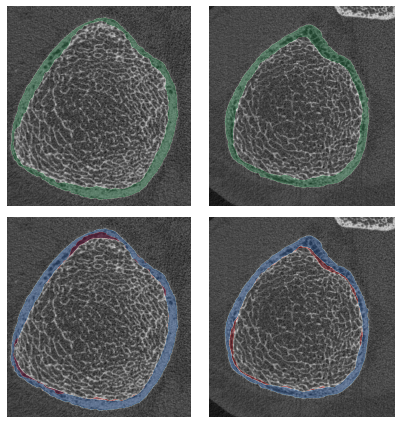

In [25]:
slice_index = 168//2

data_keys = ["over", "under"]

mask_keys = [
    "cort_mask_reference",
    "cort_mask_predicted",
    "cort_mask_disagreement"
]


fig, axs = plt.subplots(2,2,figsize=(6,6))


for c in range(2):

    single_axis_image_and_masks(
        axs[0][c],
        np.flipud(data[data_keys[c]]["aims"]["image"][:,:,slice_index]),
        [
            np.flipud(data[data_keys[c]]["aims"]["cort_mask_reference"][:,:,slice_index])
        ], 
        ['Greens']
    )
    
    single_axis_image_and_masks(
        axs[1][c],
        np.flipud(data[data_keys[c]]["aims"]["image"][:,:,slice_index]),
        [
            np.flipud(data[data_keys[c]]["aims"]["cort_mask_predicted"][:,:,slice_index]),
            np.flipud(data[data_keys[c]]["aims"]["cort_mask_disagreement"][:,:,slice_index])
        ], 
        ['Blues', 'Reds']
    )

plt.tight_layout()

fig.savefig('figures/sample_visualization.png',dpi=1200)

plt.show()